## Technical Summary and Thought Process

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler


1. _Precision over Accuracy_
As at most Kaggle competitions, my model was evaluated for **accuracy**: how well my solution predicts positive vs. negative, and true vs. false cases ([preprocessing and Kaggle-optmised solution](https://nbviewer.org/github/anikomaraz/heart_attack_kaggle/blob/main/notebooks/heart_attack_v3_clean_KaggleV1.ipynb)). Whilst accuracy is a good "general" metric, I argue that in this case **precision** is a better metric for model performance. Missing a positive case (high risk for heart attack) would potentially be fatal, thus "expensive", whereas flagging a low-risk case results "only" in higher costs due to unnecessary secondary screening, thus it is "cheap". Consequently, the model should identify the true positive cases but avoid false positives as much as possible (so we disregard the identification of negative cases) (see my [Sensible approach](https://github.com/anikomaraz/heart_attack_kaggle/blob/main/notebooks/heart_attack_v5_probability_xgboost_KaggleV2.ipynb).

Here I provide my decision process for both approaches, including preprocessing. 

2. _Task and Data_
The task was to train a model for predicting a binary target (low/high risk of heart attack) given 25 features of biometrics and lifestyle (~ 7000 train rows) and submit the prediction to Kaggle given a known set of test features (~1700). There is no information about the source of data, but given that there are no missing values and that datapoints are uniformally distributed on most variables, I assume this is an artificial or upcycled database. Means and distributions are appear to be representative to the general population.

3. _Preprocessing_

Continuous features are typically close to uniform distribution and none of the categories are extremely underrepresented. There are no outliers or missing data. Mean values and distributions appear to reflect that of the normal population. I created the following _new features_: (1) blood pressure was split into Systolic and Diastolic values and their proportion calculated and (2) cholesterol was split into low and high based on sample mean. Given the lack of outliers and near-uniform distribution of data, I opted for the **Min Max Scaler** for the coninuous variables to prepare them for gradient-based optimisation algorithms and the **One Hot Encoder** for categorical features. There was no _multicollinearity_ among features (all VIF < 4). 

4. _Kaggle model performance_
In order to obtain the highest accuracy, I tested 7 models in the pipeline. Cross-validated accuracies were the following (in decreasing order): _SVM: 0.6427, Neural Network: 0.6427, Logistic Regression: 0.6425, Random Forest: 0.6342, Gradient Boosting: 0.6330, XGBoost: 0.5953 and Decision Tree: 0.5470_. SVM and the Neural Network had the same accuracy, but **SVM** being a simplier model, I picked this for for further processing. After fine-tuning with GridSearchCV, accuracy improved to **0.6429**. The model was then trained on the entire train dataset, and predictions to the test data were made. 

5. _All things strange_

**My best, SVM-based model did not predict any positive case on the N=1700 unseen test data**. Neither did any other model with similar accuracy. Given that there were 35% positive cases on the ~7000 train data, 0% appears to be strange behaviour. I compared the train vs. test features but they did not seem to be very different from each other to account for a lack of positive cases (see below for the plots). Submitting all zeros got me to place 46 on the competition, but places 5-56 have the same accuracy - thus no-one found a model that could predict any positive cases. The data being artificial did not give me motivation to go deep into feature engineering. 

6. _Sensible Approach_
It was not only the lack of positive cases but also the fact, that risk prediction should be optimised for precision that has led me to the decision of opting for precision as a measure of goodness of fit. Optimising for precision will allow a more sensitive flagging of potentially high risk cases "in production". 

Mathematically speaking, precision is: 

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$
Thus the detection of negative cases will be ignored in this metric. 

# Pipeline print!
# model evaluation metrics print!

!(link)['../plots/continuous_distribution.png']



## 1. Data exploration

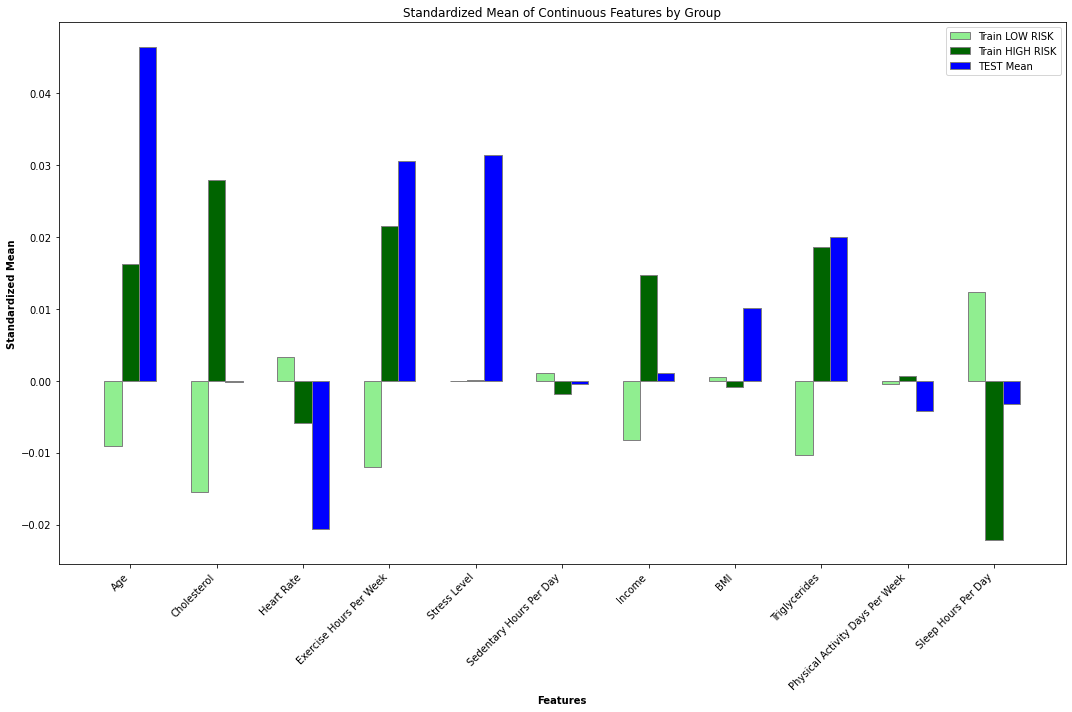

In [34]:
# Load data
df_raw_train = pd.read_csv("../data/train.csv")
df_raw_test = pd.read_csv("../data/test.csv")

# Define the group column
group_column = 'Heart Attack Risk'

# Separate continuous features
continuous_features = ['Age', 'Cholesterol', 'Heart Rate', 'Exercise Hours Per Week', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day']

# Standardize the continuous features
scaler = StandardScaler()
train_data = scaler.fit_transform(df_raw_train[continuous_features])
test_data = scaler.transform(df_raw_test[continuous_features])

# Calculate mean for standardized continuous features in df_raw_train
train_continuous_summary = pd.DataFrame(train_data, columns=continuous_features)
train_continuous_summary[group_column] = df_raw_train[group_column]

train_means = train_continuous_summary.groupby(group_column).mean().T

# Calculate mean for standardized continuous features in df_raw_test (without grouping)
test_continuous_summary = pd.DataFrame(test_data, columns=continuous_features)
test_means = test_continuous_summary.mean().to_frame().T

# Plotting
plt.figure(figsize=(15, 10))
bar_width = 0.2

# Positions for bars
r1 = range(len(continuous_features))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot bars for train group 0 and group 1
plt.bar(r1, train_means[0], color='lightgreen', width=bar_width, edgecolor='grey', label='Train LOW RISK')
plt.bar(r2, train_means[1], color='darkgreen', width=bar_width, edgecolor='grey', label='Train HIGH RISK')

# Plot bars for test set
plt.bar(r3, test_means.values[0], color='blue', width=bar_width, edgecolor='grey', label='TEST Mean')

# Add labels
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Standardized Mean', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(continuous_features))], continuous_features, rotation=45, ha='right')
plt.title('Standardized Mean of Continuous Features by Group')
plt.legend()

# Show the plot
plt.tight_layout()

# Save the plot to ../plots/
plt.savefig('../plots/continuous_distribution.png')

plt.show()


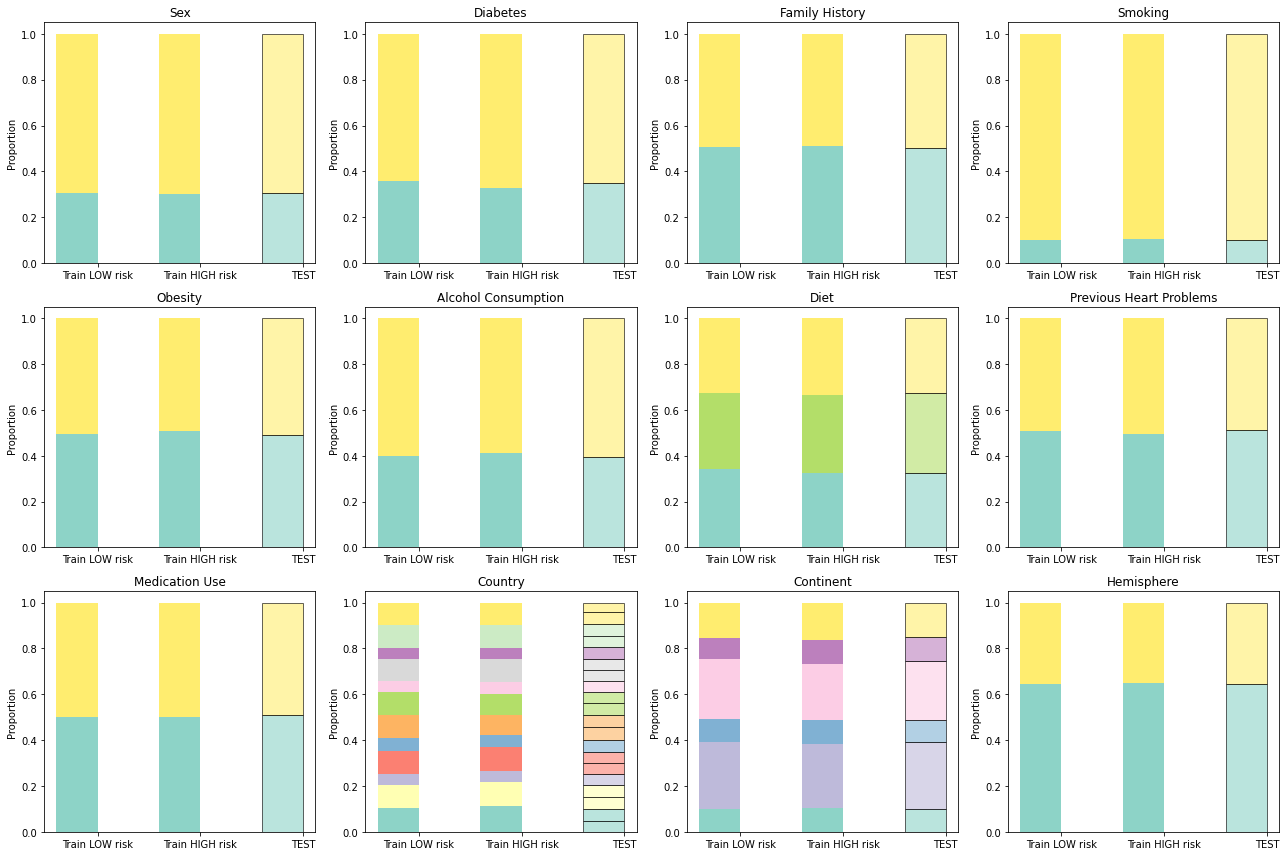

In [33]:
# Define the group column
group_column = 'Heart Attack Risk'

# Define categorical features explicitly
categorical_features = ['Sex', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 
                        'Alcohol Consumption', 'Diet', 'Previous Heart Problems', 
                        'Medication Use', 'Country', 'Continent', 'Hemisphere']

# Plotting on a larger canvas with subplots
num_features = len(categorical_features)
num_columns = 4
num_rows = (num_features + num_columns - 1) // num_columns  
fig, axes = plt.subplots(num_rows, num_columns, figsize=(18, num_rows * 4))

# Flatten the axes array to facilitate indexing
axes = axes.flatten()

# Iterate through each categorical feature
for i, feature in enumerate(categorical_features):
    # Calculate proportions for training data
    train_counts = df_raw_train.groupby([group_column])[feature].value_counts(normalize=True).unstack(fill_value=0)

    # Calculate proportions for test data 
    test_counts = df_raw_test[feature].value_counts(normalize=True)

    # Plotting each feature
    ax = axes[i]

    # Determine number of categories in current feature
    num_categories = len(train_counts.columns)

    # Use a color map for each category
    colors = plt.cm.get_cmap('Set3', num_categories)

    # Calculate cumulative widths for the bars
    train_widths = []
    for idx, group in enumerate(train_counts.index):
        cumulative_width = 0
        for j, category in enumerate(train_counts.columns):
            proportion = train_counts.loc[group, category]
            ax.bar(idx - 0.2, proportion, bottom=cumulative_width, width=0.4, color=colors(j))
            cumulative_width += proportion
        train_widths.append(cumulative_width)

    # Plot bars for the test data
    test_props = test_counts.reindex(train_counts.columns, fill_value=0).values
    cumulative_width_test = 0  
    for j, category in enumerate(train_counts.columns):
        proportion = test_props[j]
        ax.bar(2 - 0.2, proportion, bottom=cumulative_width_test, edgecolor='black', width=0.4, color=colors(j), alpha=0.6)
        cumulative_width_test += proportion

    # Set labels and title for the plot
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['Train LOW risk', 'Train HIGH risk', 'TEST'])
    ax.set_ylabel('Proportion')
    ax.set_title(f'{feature}')

# Adjust layout and remove unused subplots
for ax in axes[num_features:]:
    ax.remove()

# Adjust layout
plt.tight_layout()

# Save the plot to ../plots/
plt.savefig('../plots/categorical_distribution.png')

plt.show()


